# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов и поучаствовать в соревновании на Kaggle!
Первым делом вам предстоит построить хороший бейзлайн, а дальше пытаться улучшать, соревнуясь с другими участниками.


Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview
Данные для домашнего задания можно скачать на странице соревнования.
Чтобы ваше участие было засчитано, убедитесь, что имя в Leaderboard имеет вид: «Имя Фамилия номер_группы».

Оценивание:

Домашнее задание оценивается как обычно. Баллы указаны напротив заданий.

За соревнование даются бонусные баллы следующим образом.
Если вы пересекли baseline_2 на приватном лидерборде, ваша оценка равна 

10 - 10 * (i - 1) / M

где M — количество студентов, принявших участие в соревновании;

i — место (начиная с 1) студента в приватном лидерборде среди всех таких студентов.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* В течение 3 суток после окончания соревнования в соответствующее задание на anytask необходимо прислать код, воспроизводящий ответы для посылки, фигурирующей в приватном лидерборде. В случае отсутствия кода, воспроизводящего результат, в установленный срок студенту выставляется 0 в качестве оценки за соревнование. Если не оговорено иное, использовать любые внешние данные в соревнованиях '''запрещено'''. Под внешними данными понимаются размеченные данные, где разметка имеет прямое отношение к решаемой задаче. Грубо говоря, сборник текстов с википедии не считается внешними данными.


Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train_s = train

In [5]:
train_s.shape

(4234042, 4)

In [6]:
test.shape

(1411348, 3)

In [7]:
test_s = test

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [8]:
train_s.isnull().sum()

title            0
description      2
Category_name    0
Category         0
dtype: int64

In [9]:
test_s.isnull().sum()

title          0
description    1
itemid         0
dtype: int64

In [10]:
train_s = train_s.fillna('')

In [11]:
test_s = test_s.fillna('')

## Задание 2 (0.5 балла)
Сконкатенируйте заголовок и описание в единую строку и поместите результат в отдельный столбец. Таким образом мы будет работать с одним текстом, а не с двумя.

In [12]:
train_s['title/description'] = train_s['title'].str.cat(train_s['description'], sep =' ')

In [13]:
test_s['title/description'] = test_s['title'].str.cat(test_s['description'], sep =' ')

## Задание 3 (0.5 балла)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Сколько всего уникальных классов необходимо предсказать?
2. Постройте столбчатую диаграмму распределения по классам. Нормализуйте график, чтобы видеть доли, а не абсолютные значения.
3. На сколько большой дисбаланс? Какой класс имеет самую большую долю в выборке (укажите класс и долю), какой класс наименьшую (укажите класс и долю).

/Users/maksim/.pyenv/versions/HSE/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


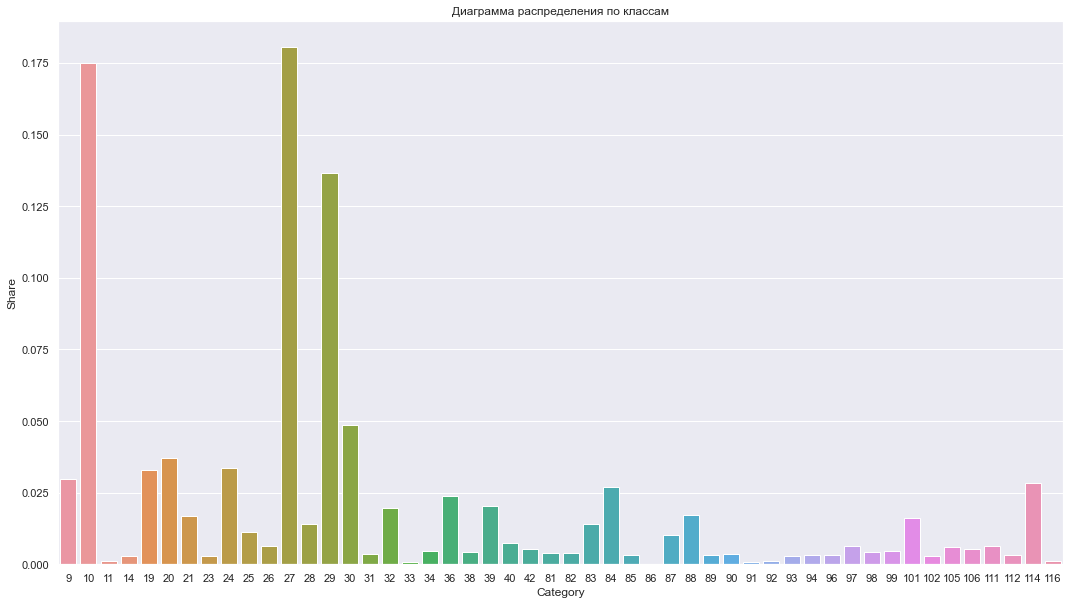

In [15]:
x = train_s['Category'].value_counts().keys()
y = train_s['Category'].value_counts() / train_s['Category'].size

sns.set(rc={'figure.figsize':(18, 10)})
sns.barplot(x, y)

plt.title('Диаграммa распределения по классам')

plt.xlabel('Category')
plt.ylabel('Share')
plt.show()

In [16]:
c_mode = train_s['Category'].mode().iloc[0]

In [17]:
c_mode, train_s[train_s['Category'] == c_mode].shape[0]

(27, 765120)

In [18]:
c_least = train_s['Category'].value_counts().index[-1]

In [19]:
c_least, train_s[train_s['Category'] == c_least].shape[0]

(86, 165)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью. Для test части нам неизвестны истинные значения, и они понадобятся только тогда, когда мы будем отправлять решение на Kaggle.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [20]:
cnt_vect = CountVectorizer()

In [21]:
train_vect = cnt_vect.fit_transform(train_s['title/description'])

In [22]:
train_vect.shape

(4234042, 2125805)

## Задание 5 (0.5 балла)

В предыдущем пункте у вас должная была получится очень большая матрица. Это не дело.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле _vocabulary инстанса этого класса.

1. Найдите в этом словаре все слова, которые начинаются на цифру. Сколько таких слов нашлось?

2. Найдите все слова, которые начинаются на символы пунктуации. Сколько таких слов нашлось? 

In [23]:
vocabulary = cnt_vect.vocabulary_

In [24]:
from string import punctuation

In [25]:
sum(list(map(lambda x: re.match(r'[0-9]', x) != None, vocabulary.keys())))

610871

In [26]:
len(list(filter(lambda x: x[0] in set(punctuation), vocabulary.keys())))

2043

## Задание 6 (2.5 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью word_tokenizer из пакета nltk
2. Удалит все токены содержащие числа и пунктуацию
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функии на самом первом описании товара в датасете.

Важно: так как функию будет необходимо запускать на большом корпусе, подумайте об эффективной реализации. Постарайтесь решить задачу в минимальное количество циклов и копирований.

Референсная реализация на компьютере автора работала 230 секунд на 100к строчек.

In [30]:
stop_words = stopwords.words('russian')
st = SnowballStemmer('russian')

In [32]:
def token(text):
    tokens = word_tokenize(text.lower())
    tokens = [st.stem(token) for token in tokens if (token.isalpha() and token not in stop_words)]
    return tokens

In [33]:
print(token(train_s['title/description'][0]))

['эб', 'renault', 'nissan', 'dci', 'delphi', 'год', 'комплект', 'эб', 'мозг', 'компьютер', 'мотор', 'двигател', 'коммутатор', 'электрон', 'блок', 'управлен', 'двигател', 'компьютер', 'мотор', 'рен', 'kangoo', 'канг', 'канг', 'мега', 'сценик', 'laguna', 'лагун', 'clio', 'кли', 'nissan', 'micra', 'нисса', 'микр', 'друг', 'рен', 'нисса', 'дизел', 'топливн', 'аппаратур', 'делф', 'оригина', 'отличн', 'состоян', 'проверен', 'гарант', 'запчаст', 'предоставля', 'гарант', 'возможн', 'установк', 'подробн', 'раздел', 'компан', 'дорож', 'сво', 'репутац', 'торгу', 'легальн', 'контрактн', 'запчаст', 'дета', 'налич', 'таможен', 'документ', 'запчаст', 'автомобил', 'пробег', 'росс', 'отправля', 'друг', 'регион', 'таможен', 'союз', 'транспортн', 'компан', 'наложн', 'платеж']


## Задание 7 (1 балл)

1. Возьмите случайные 500к строк из датасета. Постройте по ним CountVectorizer с применением вашего токенизатора.
2. Разбейте полученную матрицу на train, test в отношении 4 к 1. Не забудьте про target переменную.
3. Обучите SGDClassifier на полученной выборке.
4. Посчитайте метрику accuracy

In [34]:
train_s = train_s.sample(50000)

In [35]:
cnt_vect = CountVectorizer(tokenizer=token)

In [36]:
train_vect = cnt_vect.fit_transform(train_s['title/description'])

In [37]:
train_vect.shape

(50000, 58881)

In [42]:
target = train_s['Category']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_vect, target, train_size=0.75, random_state=165)

In [44]:
SGD = SGDClassifier(n_jobs = -1)
cnt_vec_pred = SGD.fit(X_train, y_train)

In [45]:
accuracy_score(y_test, cnt_vec_pred.predict(X_test))

0.80032

## Задание 8 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество.
2. Мы можем еще сильнее уменьшите размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [63]:
tf_vect = TfidfVectorizer(tokenizer=token)

In [64]:
train_tf_vect = tf_vect.fit_transform(train_s['title/description'])

In [65]:
train_tf_vect.shape

(50000, 58881)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(train_tf_vect, target, train_size=0.75, random_state=165)

In [67]:
np.random.seed(165)
SGD = SGDClassifier(n_jobs = -1)
tf_pred = SGD.fit(X_train, y_train)

In [68]:
accuracy_score(y_test, tf_pred.predict(X_test))

0.81736

In [69]:
tf_vect = TfidfVectorizer(tokenizer=token, max_df = 0.9)

In [70]:
train_tf_vect = tf_vect.fit_transform(train_s['title/description'])

In [71]:
train_tf_vect.shape

(50000, 58881)

Размер матрицы не изменился

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train_tf_vect, target, train_size=0.75, random_state=165)

In [73]:
np.random.seed(165)
SGD = SGDClassifier(n_jobs = -1)
tf_pred = SGD.fit(X_train, y_train)

In [74]:
accuracy_score(y_test, tf_pred.predict(X_test))

0.81736

Качество не изменилось

## Задание 9 (1 балл)
Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 30000.
2. Какой из трех подходов показал самый высокий результат?

In [104]:
h_vect = HashingVectorizer(tokenizer=token, token_pattern=None, n_features = 30000)                                            

In [105]:
train_h_vect = h_vect.fit_transform(train_s['title/description'])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_h_vect, target, train_size=0.75, random_state=165)

In [61]:
SGD_h = SGDClassifier(n_jobs = -1)
h_pred = SGD.fit(X_train, y_train)

In [62]:
accuracy_score(y_test, h_pred.predict(X_test))

0.80232

Подход с tf-idf векторайзером показал самое высокое качество

## Задание 10 (1.5 балла)

Пришло время выйти в мир. Отправляйтесь на Kaggle Inclass и сделайте первую посылку. Там вы найдете инструкцию как сформировать файл с предсказаниями и отправить его.

In [100]:
result_vect = TfidfVectorizer()
result_X = result_vect.fit_transform(train_s['title/description'])
model = SGDClassifier(n_jobs = -1)
result_pred = model.fit(result_X, train_s['Category'])

In [101]:
prediction = model.predict(result_vect.transform(test_s['title/description']))

In [102]:
df = pd.DataFrame({'Id': test_s['itemid'], 'Category': prediction})

In [103]:
df.to_csv('submission.csv', index=False)